https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py

In [2]:
''' 
This script does conditional image generation on MNIST, using a diffusion model
This code is modified from,
https://github.com/cloneofsimo/minDiffusion
Diffusion model is based on DDPM,
https://arxiv.org/abs/2006.11239
The conditioning idea is taken from 'Classifier-Free Diffusion Guidance',
https://arxiv.org/abs/2207.12598
This technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Modelswith Deep Language Understanding',
https://arxiv.org/abs/2205.11487
'''

" \nThis script does conditional image generation on MNIST, using a diffusion model\nThis code is modified from,\nhttps://github.com/cloneofsimo/minDiffusion\nDiffusion model is based on DDPM,\nhttps://arxiv.org/abs/2006.11239\nThe conditioning idea is taken from 'Classifier-Free Diffusion Guidance',\nhttps://arxiv.org/abs/2207.12598\nThis technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Modelswith Deep Language Understanding',\nhttps://arxiv.org/abs/2205.11487\n"

In [13]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

In [4]:
import os

# Specify the directory path
directory_path = "./data/diffusion_outputs10"

# Check if the directory already exists
if not os.path.exists(directory_path):
    # Create the directory
    os.makedirs(directory_path)


In [5]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [6]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [
            ResidualConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [7]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [8]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embeddings  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [9]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask tells which samples to block the context on
        # returns denoised image

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [10]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    beta1: intial value of DDPM beta parameter
    beta2: final value of DDPM beta parameter
    T: number of time steps
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [11]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store
    
    def x_noise(self, x, device, n_start):
        _ts = torch.ones((x.shape[0],), device=device).long()*n_start
        _ts = _ts.type(torch.int64)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.
        
        return x_t
    
    def custom_sample(self, x_noisy, batch_size, size, c, start_idx, repeats, device):
        context_mask = torch.zeros_like(c).to(device)
        x_store = []

        for i in range(repeats):
            for j in range(start_idx, 0, -1):
                t_is = torch.tensor([j / self.n_T]).to(device)
                t_is = t_is.repeat(batch_size,1,1,1)
                z = torch.randn(batch_size, *size).to(device) if j > 1 else 0
                
                # split predictions and compute weighting
                eps = self.nn_model(x_noisy, c, t_is, context_mask)
                x_noisy = (
                    self.oneover_sqrta[j] * (x_noisy - eps * self.mab_over_sqrtmab[j])
                    + self.sqrt_beta_t[j] * z
                )
                if j%max(1, start_idx//5)==0 or j==start_idx or j==1:
                    x_store.append(x_noisy.detach().cpu().numpy())

        x_store = np.array(x_store)
        return x_noisy, x_store

In [14]:
def train_mnist():
    loss_all = []
    # n_epoch = 20
    n_epoch = 40
    batch_size = 256
    n_T = 400 # 500
    device = "cuda:0"
    n_classes = 10
    n_feat = 128 # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = True
    save_dir = './data/diffusion_outputs10/'
    ws_test = [0.0, 0.5, 2.0] # strength of generative guidance(w)

    ddpm = DDPM(
        nn_model=ContextUnet(
            in_channels=1,
            n_feat=n_feat,
            n_classes=n_classes
        ),
        betas=(1e-4, 0.02),
        n_T=n_T, device=device,
        drop_prob=0.1
    )
    ddpm.to(device)

    tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

    dataset = MNIST("./data", train=True, download=True, transform=tf)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)
    loss_array = []

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
            
        print('Loss ema:',loss_ema)
        print('loss',loss)
        loss_all.append(loss_ema)
        
        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4*n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample/n_classes)):
                        try: 
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all*-1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
#                 print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")
        
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_mist_{ep}.pth")
            print('saved model at ' + save_dir + f"model__{ep}.pth")
            return loss_all

In [15]:
loss = train_mnist()

100%|██████████| 9912422/9912422 [00:00<00:00, 142878733.84it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25142319.18it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39027411.02it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22625331.08it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

epoch 0


loss: 0.0501: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


Loss ema: 0.05006943953021802
loss tensor(0.0432, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 1


loss: 0.0385: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.03845263390208207
loss tensor(0.0410, device='cuda:0', grad_fn=<MseLossBackward0>)


sampling timestep 1
epoch 2


loss: 0.0347: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.03467225260057185
loss tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 3


loss: 0.0317: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.03172325345138416
loss tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 4


loss: 0.0314: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.031423077691620636
loss tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 5


loss: 0.0295: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.029492150353439543
loss tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 6


loss: 0.0296: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.029585004521501364
loss tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 7


loss: 0.0281: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.028108483422609583
loss tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 8


loss: 0.0277: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.02773255192608207
loss tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 9


loss: 0.0275: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02745860511689983
loss tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 10


loss: 0.0264: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02644823222257472
loss tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 11


loss: 0.0267: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.026686238480576562
loss tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 12


loss: 0.0263: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.02633567386923016
loss tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 13


loss: 0.0257: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02573755839232641
loss tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 14


loss: 0.0253: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.025253363640977605
loss tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 15


loss: 0.0255: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.02545894607023367
loss tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 16


loss: 0.0241: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.024132703910040177
loss tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 17


loss: 0.0246: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.024621523033283854
loss tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 18


loss: 0.0252: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.025216290166222854
loss tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 19


loss: 0.0244: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.02443772280649973
loss tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 20


loss: 0.0236: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.023582961541963644
loss tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 21


loss: 0.0247: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


Loss ema: 0.024695268881547303
loss tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 22


loss: 0.0241: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02406589605949302
loss tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 23


loss: 0.0251: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.02513213550114049
loss tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 24


loss: 0.0239: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.023946871249835865
loss tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 25


loss: 0.0235: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.023481468600381205
loss tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 26


loss: 0.0233: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.02329316150439675
loss tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 27


loss: 0.0228: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.022833129499137454
loss tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 28


loss: 0.0241: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.024076029706950296
loss tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 29


loss: 0.0235: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.023468567249791555
loss tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 30


loss: 0.0237: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.023730095597611602
loss tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 31


loss: 0.0230: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02300945763214891
loss tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 32


loss: 0.0232: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


Loss ema: 0.02319597520486069
loss tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 33


loss: 0.0232: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02321647809496844
loss tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 34


loss: 0.0233: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.023292308128385866
loss tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 35


loss: 0.0231: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02311946266873455
loss tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 36


loss: 0.0231: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.02312198052467593
loss tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 37


loss: 0.0232: 100%|██████████| 235/235 [01:43<00:00,  2.28it/s]


Loss ema: 0.023212253242482685
loss tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)

sampling timestep 1
sampling timestep 1
epoch 38


loss: 0.0231: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Loss ema: 0.023085589202472105
loss tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)



epoch 39


loss: 0.0224: 100%|██████████| 235/235 [01:42<00:00,  2.28it/s]


Loss ema: 0.022438952790605326
loss tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)



saved model at ./data/diffusion_outputs10/model__39.pth


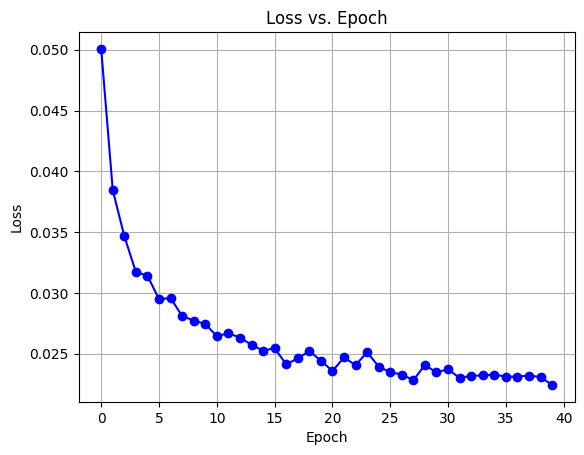

In [18]:
import matplotlib.pyplot as plt

# Example data
# epochs = list(range(1,51))
epochs = list(range(40))
loss_values = loss


# Plotting the graph
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.grid(True)

# Show the plot
plt.show()


In [19]:
# hardcoding these here
# n_epoch = 20
batch_size = 256
n_T = 400 # 500
device = "cpu:0"
n_classes = 10
n_feat = 128 # 128 ok, 256 better (but slower)
# lrate = 1e-4
# save_model = False
model_dir = './data/diffusion_outputs10/model_mist_39.pth'
save_dir = './data/diffusion_outputs10/'
# ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

In [20]:
# optionally load a model

ddpm = DDPM(
    nn_model=ContextUnet(
        in_channels=1,
        n_feat=n_feat,
        n_classes=n_classes
    ),
    betas=(1e-4, 0.02),
    n_T=n_T, device=device,
    drop_prob=0.1
)

ddpm.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))
ddpm.to(device)

DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 

In [24]:
# tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

# dataset = FashionMNIST("./data", train=True, download=True, transform=tf)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)

ddpm.eval()
for x_,c_ in dataloader:
    x_ = x_.to(device)
    c_ = c_.to(device)

# next(iter(data_loader))

In [25]:
def plot_graphs(features, labels, noise_start, num_samples, start_index, repeats, device):
    for i in range(num_samples):
        x_i = features[i:i+1]
        c_i = labels[i:i+1]
        x_noisy = ddpm.x_noise(x=x_i, device=device, n_start=noise_start)
        x_gen, x_store = ddpm.custom_sample(x_noisy, x_i.shape[0], (1,28,28), c_i, start_index, repeats, device)
        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(15,15))
        ax1.imshow(x_i.reshape(28,28), cmap="gray")
        if repeats==1:
            ax2.imshow(x_store[0].reshape(28,28), cmap="gray")
            ax3.imshow(x_store[1].reshape(28,28), cmap="gray")
            ax4.imshow(x_store[2].reshape(28,28), cmap="gray")
            ax5.imshow(x_store[3].reshape(28,28), cmap="gray")
            ax6.imshow(x_store[4].reshape(28,28), cmap="gray")
            ax7.imshow(x_store[5].reshape(28,28), cmap="gray")
            plt.imsave(f"subplot_{i}.png", x_store[5].reshape(28,28), cmap="gray")
            score = nn.MSELoss((x_store[5].reshape(28,28)).all(), (x_store[0].reshape(28,28)).all(), reduction='mean')
        if repeats==3:
            ax2.imshow(x_store[0].reshape(28,28), cmap="gray")
            ax3.imshow(x_store[3].reshape(28,28), cmap="gray")
            ax4.imshow(x_store[7].reshape(28,28), cmap="gray")
            ax5.imshow(x_store[10].reshape(28,28), cmap="gray")
            ax6.imshow(x_store[14].reshape(28,28), cmap="gray")
            ax7.imshow(x_store[17].reshape(28,28), cmap="gray")
            plt.imsave(f"subplot_{i}.png", x_store[5].reshape(28,28), cmap="gray")
            score = nn.MSELoss((x_store[17].reshape(28,28)).all(), (x_store[0].reshape(28,28)).all(), reduction='mean')
            print(score)
        if repeats==40 and start_index==2:
            ax2.imshow(x_store[0].reshape(28,28), cmap="gray")
            ax3.imshow(x_store[16].reshape(28,28), cmap="gray")
            ax4.imshow(x_store[32].reshape(28,28), cmap="gray")
            ax5.imshow(x_store[48].reshape(28,28), cmap="gray")
            ax6.imshow(x_store[64].reshape(28,28), cmap="gray")
            ax7.imshow(x_store[79].reshape(28,28), cmap="gray")
            plt.imsave(f"subplot_{i}.png", x_store[5].reshape(28,28), cmap="gray")
            score = nn.MSELoss((x_store[79].reshape(28,28)).all(), (x_store[0].reshape(28,28)).all(), reduction='mean')
            print(score)
        if repeats!=1 and repeats!=3 and repeats!=40:
            print("repeats should be 1, 3 or 40")
        plt.show()

In [26]:
n_start = 160
n_sample = 5
x = x_[:n_sample]
c = c_[:n_sample]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


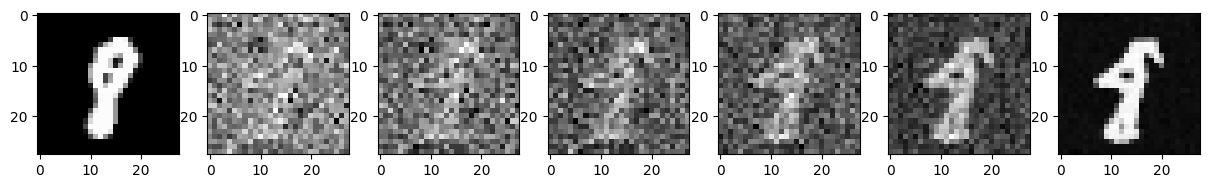

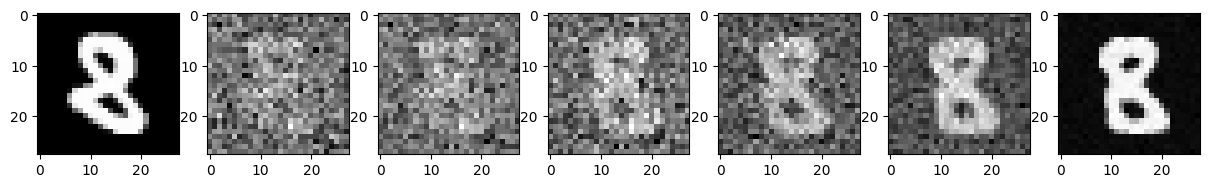

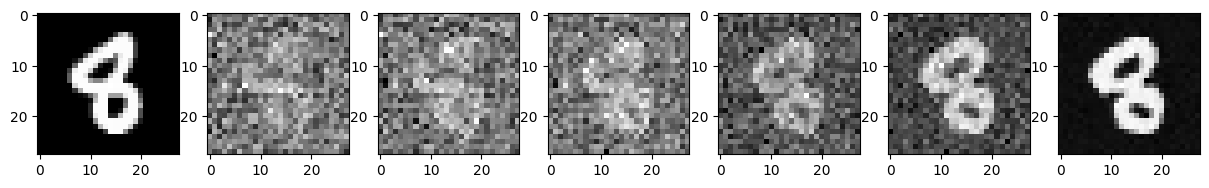

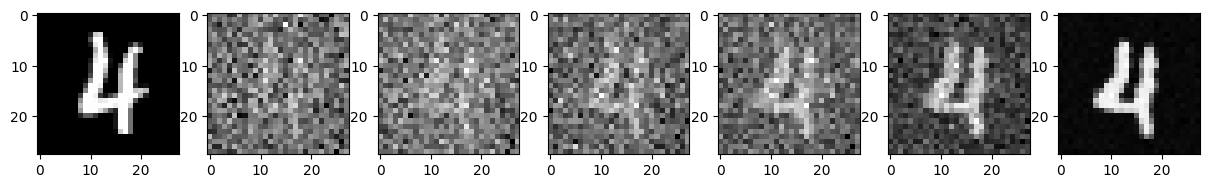

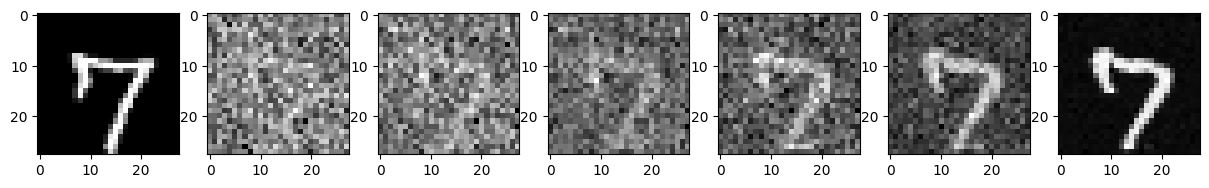

In [27]:
start_idx = 160 # 80% of 200 (starting index)
repeats = 1 # int representing the number of times to repeat the process


plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

In [ ]:
start_idx = 2
repeats = 40

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)

MSELoss()


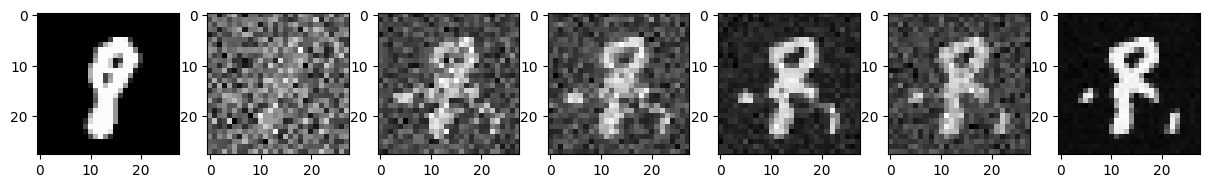

MSELoss()


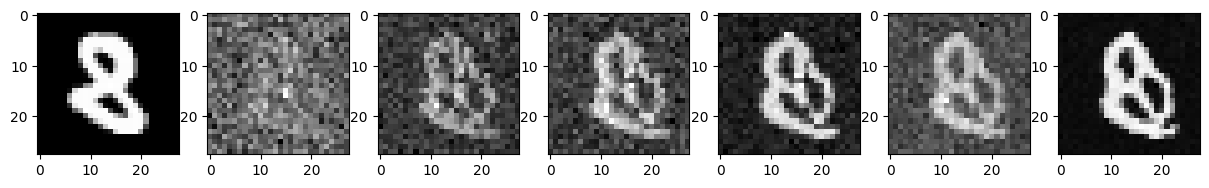

MSELoss()


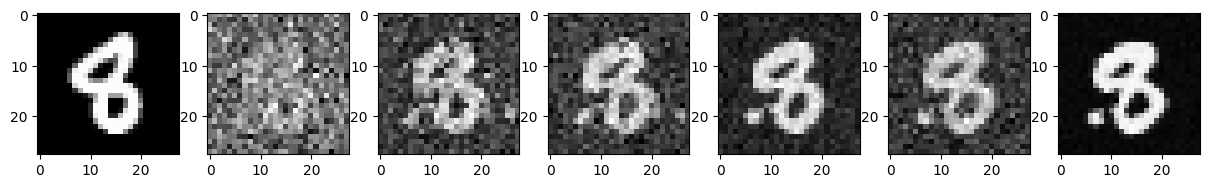

MSELoss()


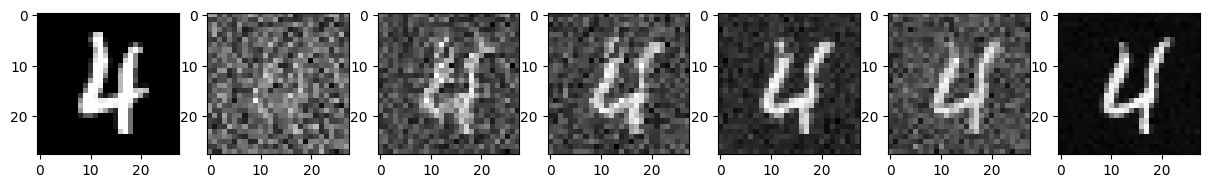

MSELoss()


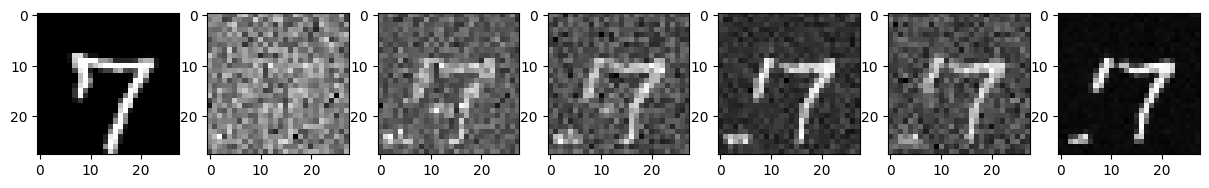

In [28]:
start_idx = 60 # 30% of 200
repeats = 3

plot_graphs(x, c, n_start, n_sample, start_idx, repeats, device)